<a href="https://colab.research.google.com/github/Shalinda99/nyc-taxi-spark-analysis-revenue-prof/blob/main/BigData_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYC-Taxi Data Analysis


In [6]:
# # Import necessary libraries
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import col, to_timestamp, hour, dayofweek, year, month, dayofmonth
# import os
# import matplotlib.pyplot as plt

#### Data Ingestion ,Preprocessing and Feature Engineering

In this section, we load multiple monthly NYC Yellow Taxi Parquet files, clean the data, convert date fields to timestamps, and engineer new time-based features (e.g., hour, day of week). The resulting DataFrame is cached and registered as a temporary SQL view for reuse in later sections.

In [7]:
# # Initialize SparkSession
# spark = SparkSession.builder \
#     .appName("NYC Taxi Data Analysis") \
#     .config("spark.sql.execution.arrow.enabled", "true") \
#     .getOrCreate()

In [8]:
# data_dir = "data"
# file_prefix = "yellow_tripdata"

# file_paths = []

# # Add files for 2020–2024 (all months)
# for year in range(2020, 2025):
#     for month in range(1, 13):
#         path = os.path.join(data_dir, f"{file_prefix}_{year}-{str(month).zfill(2)}.parquet")
#         if os.path.exists(path):
#             file_paths.append(path)

# # Add files for 2025 (only Jan–Mar)
# for month in range(1, 4):
#     path = os.path.join(data_dir, f"{file_prefix}_2025-{str(month).zfill(2)}.parquet")
#     if os.path.exists(path):
#         file_paths.append(path)


In [9]:
# # 🧾 Load multiple monthly Parquet files
# if file_paths:
#     df = spark.read.parquet(*file_paths)
# else:
#     print("No valid files found.")

In [10]:
!pip install -q pyspark

# 🔧 Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, hour, dayofweek, year, month, dayofmonth, sum as spark_sum
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# 🔗 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📁 Path to your data folder inside Google Drive
data_dir = "/content/drive/MyDrive/nyc_data"
file_prefix = "yellow_tripdata"

# ✅ Initialize SparkSession
spark = SparkSession.builder \
    .appName("NYC Taxi Data Analysis") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

# 🗂️ Collect matching file paths from the directory
file_paths = []

# Files from 2020–2024 (all months)
for year in range(2020, 2025):
    for month in range(1, 13):
        path = os.path.join(data_dir, f"{file_prefix}_{year}-{str(month).zfill(2)}.parquet")
        if os.path.exists(path):
            file_paths.append(path)

# Files for 2025 (Jan–Mar)
for month in range(1, 4):
    path = os.path.join(data_dir, f"{file_prefix}_2025-{str(month).zfill(2)}.parquet")
    if os.path.exists(path):
        file_paths.append(path)

# ✅ Load Parquet files if available
if file_paths:
    print(f"Loading {len(file_paths)} Parquet files...")
    df = spark.read.parquet(*file_paths)
    df.cache()
    print("✅ DataFrame loaded and cached.")
else:
    print("❌ No valid Parquet files found.")

# 🔍 Preview DataFrame
df.show(5)


Mounted at /content/drive
Loading 3 Parquet files...
✅ DataFrame loaded and cached.
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-03-01 00:17:16|  2025-03-01 00

In [11]:
df

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double, cbd_congestion_fee: double]

In [12]:
# Show schema
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



In [13]:
# df.show(3)

In [14]:
# Alternative way
pandas_df = df.limit(3).toPandas()
pandas_df.style.set_table_attributes('style="max-height:300px; overflow-y: auto; display:block;"')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-03-01 00:17:16,2025-03-01 00:25:52,1,0.900000,1,N,140,236,1,7.900000,3.500000,0.500000,2.600000,0.000000,1.000000,15.500000,2.500000,0.000000,0.000000
1,1,2025-03-01 00:37:38,2025-03-01 00:43:51,1,0.600000,1,N,140,262,1,6.500000,3.500000,0.500000,2.300000,0.000000,1.000000,13.800000,2.500000,0.000000,0.000000
2,2,2025-03-01 00:24:35,2025-03-01 00:39:49,1,1.940000,1,N,161,68,1,14.900000,1.000000,0.500000,5.160000,0.000000,1.000000,25.810000,2.500000,0.000000,0.750000



#####  Data Type Conversion (datetime fields)
Convert string-type datetime fields (tpep_pickup_datetime, tpep_dropoff_datetime) into timestamp data type, which allows for proper datetime operations (e.g., sorting, filtering by date, calculating durations)

In [15]:
df = df.withColumn("pickup_datetime", to_timestamp("tpep_pickup_datetime")) \
       .withColumn("dropoff_datetime", to_timestamp("tpep_dropoff_datetime"))

##### Counting and Filtering Invalid Entries
Before removing invalid records, we count how many entries have non-positive values or missing timestamps. This helps assess data quality before applying the cleaning logic

In [16]:
# Basic Cleaning: Filter out invalid entries
from pyspark.sql.functions import col

# Define the filter condition for valid rows
valid_condition = (
    (col("trip_distance") > 0) &
    (col("fare_amount") > 0) &
    (col("pickup_datetime").isNotNull()) &
    (col("dropoff_datetime").isNotNull())
)

# Count invalid entries (negation of the valid condition)
invalid_count = df.filter(~valid_condition).count()
print(f"Number of invalid entries: {invalid_count}")

# Apply the filter to keep only valid rows
df = df.filter(valid_condition)


Number of invalid entries: 784674


##### Extracting Date and Time Components from pickup_datetime
To enable time-based analysis and modeling, we extract useful temporal features such as hour, day of the week, day of the month, month, and year from the pickup_datetime column

In [17]:
# from pyspark.sql.functions import hour, dayofweek, dayofmonth, month, year

# df = df.withColumn("pickup_hour", hour("pickup_datetime")) \
#        .withColumn("day_of_week", dayofweek("pickup_datetime")) \
#        .withColumn("day", dayofmonth("pickup_datetime")) \
#        .withColumn("month", month("pickup_datetime")) \
#        .withColumn("year", year("pickup_datetime"))

In [18]:
# Show schema and sample data
# df.printSchema()

In [19]:
pandas_df = df.limit(3).toPandas()
pandas_df.style.set_table_attributes('style="max-height:300px; overflow-y: auto; display:block;"')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,pickup_datetime,dropoff_datetime
0,1,2025-03-01 00:17:16,2025-03-01 00:25:52,1,0.900000,1,N,140,236,1,7.900000,3.500000,0.500000,2.600000,0.000000,1.000000,15.500000,2.500000,0.000000,0.000000,2025-03-01 00:17:16,2025-03-01 00:25:52
1,1,2025-03-01 00:37:38,2025-03-01 00:43:51,1,0.600000,1,N,140,262,1,6.500000,3.500000,0.500000,2.300000,0.000000,1.000000,13.800000,2.500000,0.000000,0.000000,2025-03-01 00:37:38,2025-03-01 00:43:51
2,2,2025-03-01 00:24:35,2025-03-01 00:39:49,1,1.940000,1,N,161,68,1,14.900000,1.000000,0.500000,5.160000,0.000000,1.000000,25.810000,2.500000,0.000000,0.750000,2025-03-01 00:24:35,2025-03-01 00:39:49


In [20]:
# Register as Temp View for SQL Queries
df.createOrReplaceTempView("yellow_taxi_trips")

In [21]:
from pyspark.sql.functions import to_timestamp
# Show basic statistics
# print("Summary statistics (trip_distance, fare_amount):")
df.select("trip_distance", "fare_amount").describe().show()

+-------+-----------------+------------------+
|summary|    trip_distance|       fare_amount|
+-------+-----------------+------------------+
|  count|         10413352|          10413352|
|   mean|5.825326975406465| 18.52100415696364|
| stddev|532.6486725379601|271.54243178813044|
|    min|             0.01|              0.01|
|    max|        281085.57|         863372.12|
+-------+-----------------+------------------+



## Section 1: Descriptive Analysis

## Section 2: Geospatial Analysis

This section focuses on spatial trends by identifying high-demand pickup zones. We aggregate pickups by location, merge with NYC taxi zone shapefile data, and create geospatial visualizations showing demand hotspots across the city.

Objective:
- Identify popular pickup zones.

- Visualize demand hotspots in NYC.

- Optionally, export data for map visualization (e.g., with Folium or GeoPandas).



In [ ]:
# zone_df = spark.read.csv("data/taxi_zone_lookup.csv", header=True, inferSchema=True)

# # Join with pickup zone
# df = df.join(zone_df, df.PULocationID == zone_df.LocationID, "left") \
#        .withColumnRenamed("Borough", "pickup_borough") \
#        .withColumnRenamed("Zone", "pickup_zone") \
#        .drop("service_zone", "LocationID")


In [ ]:
pickup_counts = df.groupBy("pickup_borough", "pickup_zone") \
                  .count() \
                  .orderBy("count", ascending=False)

pickup_counts.show(10, truncate=False)


In [ ]:
pickup_pd = pickup_counts.toPandas()
pickup_pd.to_csv("output/popular_pickup_zones.csv", index=False)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV you exported from Spark
df2 = pd.read_csv("output/popular_pickup_zones.csv")

# Get top 10 zones
top10 = df2.sort_values(by="count", ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top10["pickup_zone"], top10["count"], color="skyblue")
plt.xlabel("Number of Pickups")
plt.ylabel("Pickup Zone")
plt.title("Top 10 NYC Taxi Pickup Zones (Jan 2025)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
!pip install geopandas -q

In [ ]:
# Group pickup counts by location
pickup_by_zone = df.groupBy("PULocationID").count()

# Convert to Pandas
pickup_pd = pickup_by_zone.toPandas()


In [ ]:
# import geopandas as gpd

# Load shapefile
gdf = gpd.read_file("data/taxi_zones/taxi_zones.shp")

# Merge on LocationID
merged = gdf.merge(pickup_pd, left_on="LocationID", right_on="PULocationID")


In [ ]:
plt.figure(figsize=(12, 10))
merged.plot(column="count", cmap="OrRd", legend=True, edgecolor="black")
plt.title("NYC Taxi Pickup Density by Zone (Jan 2025)")
plt.axis("off")
plt.show()


## Section 3:Revenue and Profitability Analysis

This section focuses on evaluating the financial performance of NYC taxi services. It includes breakdowns of revenue, profitability patterns over time, and other financial indicators.

### A. Total Revenue Breakdown by Day, Month, and Vendor

In this analysis, we break down the total fare revenue by:

*   Day of the Week (to understand weekly trends)
*   Month (to identify seasonal patterns)
*   Vendor ID (to compare revenue performance between taxi companies)


This helps uncover which days and months are most profitable and whether certain vendors consistently generate higher revenue.

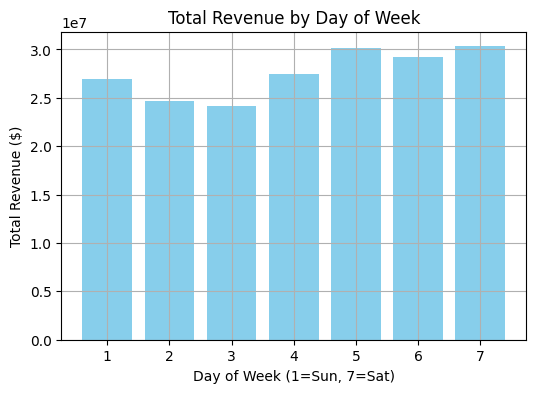

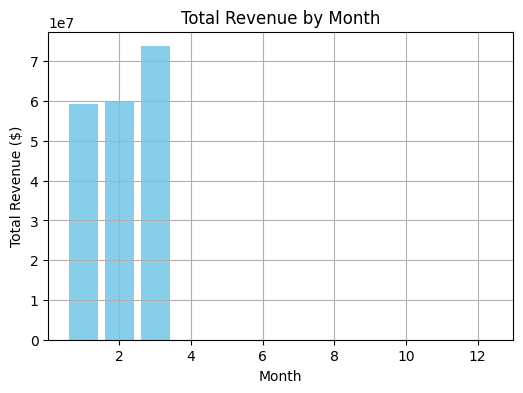

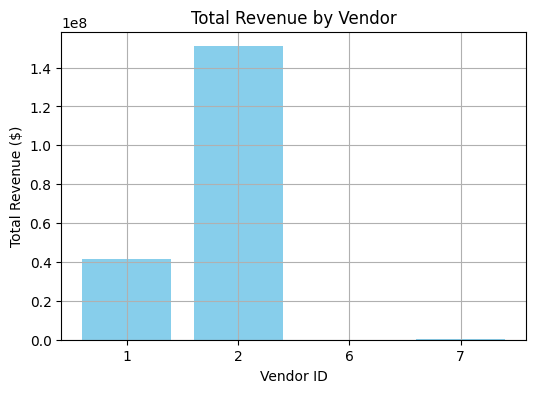

Highest Revenue Day of Week: Day 7 with $30311839.11
Highest Revenue Month: Month 3 with $73753664.01
Highest Revenue Vendor: Vendor ID 2 with $150903734.03


In [43]:
from pyspark.sql.functions import dayofweek, month, year, sum as spark_sum
import matplotlib.pyplot as plt

# Create temporary view for SQL-style queries (optional but useful)
df.createOrReplaceTempView("taxi_data")

# Total revenue by day of week
revenue_by_day = df.withColumn("day_of_week", dayofweek("pickup_datetime")) \
                   .groupBy("day_of_week") \
                   .agg(spark_sum("fare_amount").alias("total_revenue")) \
                   .orderBy("day_of_week")

# Total revenue by month
revenue_by_month = df.withColumn("month", month("pickup_datetime")) \
                     .groupBy("month") \
                     .agg(spark_sum("fare_amount").alias("total_revenue")) \
                     .orderBy("month")

# Total revenue by vendor
revenue_by_vendor = df.groupBy("VendorID") \
                      .agg(spark_sum("fare_amount").alias("total_revenue")) \
                      .orderBy("VendorID")

# Convert to Pandas for plotting
rev_day_pd = revenue_by_day.toPandas()
rev_month_pd = revenue_by_month.toPandas()
rev_vendor_pd = revenue_by_vendor.toPandas()

# Plot: Revenue by Day of Week
plt.figure(figsize=(6,4))
plt.bar(rev_day_pd['day_of_week'], rev_day_pd['total_revenue'], color='skyblue')
plt.xlabel("Day of Week (1=Sun, 7=Sat)")
plt.ylabel("Total Revenue ($)")
plt.title("Total Revenue by Day of Week")
plt.grid(True)
plt.show()

# Plot: Revenue by Month
plt.figure(figsize=(6,4))
plt.bar(rev_month_pd['month'], rev_month_pd['total_revenue'], color='skyblue')
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.title("Total Revenue by Month")
plt.grid(True)
plt.show()

# Plot: Revenue by Vendor
plt.figure(figsize=(6,4))
plt.bar(rev_vendor_pd['VendorID'].astype(str), rev_vendor_pd['total_revenue'], color='skyblue')
plt.xlabel("Vendor ID")
plt.ylabel("Total Revenue ($)")
plt.title("Total Revenue by Vendor")
plt.grid(True)
plt.show()

# Find highest revenue by day of week
max_day = revenue_by_day.orderBy(desc("total_revenue")).first()

# Find highest revenue by month
max_month = revenue_by_month.orderBy(desc("total_revenue")).first()

# Find highest revenue by vendor
max_vendor = revenue_by_vendor.orderBy(desc("total_revenue")).first()

print(f"Highest Revenue Day of Week: Day {max_day['day_of_week']} with ${max_day['total_revenue']:.2f}")
print(f"Highest Revenue Month: Month {max_month['month']} with ${max_month['total_revenue']:.2f}")
print(f"Highest Revenue Vendor: Vendor ID {max_vendor['VendorID']} with ${max_vendor['total_revenue']:.2f}")


The day of the week with the highest revenue shows when taxi demand is strongest during the week.

The month with the highest revenue indicates the peak season for taxi rides.

The vendor with the highest revenue consistently generates more business than others.

### B. Average Revenue per Mile and per Minute

This section evaluates the earning efficiency of taxi trips by calculating:

*   Average revenue per mile (how much is earned for every mile traveled)
*   Average revenue per minute (how much is earned for each minute of trip time)

These metrics help assess how profitable trips are relative to distance and time useful for comparing short vs. long trips or identifying inefficiencies.

In [23]:
from pyspark.sql.functions import col, unix_timestamp, avg

# Calculate trip duration in minutes
df_with_duration = df.withColumn("trip_duration_minutes",
    (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60
)

# Filter out invalid data: zero/negative trip distance or duration
df_valid = df_with_duration.filter(
    (col("trip_distance") > 0) &
    (col("trip_duration_minutes") > 0) &
    (col("fare_amount") > 0)
)

# Calculate revenue per mile and per minute
df_revenue_efficiency = df_valid.withColumn("revenue_per_mile", col("fare_amount") / col("trip_distance")) \
                                .withColumn("revenue_per_minute", col("fare_amount") / col("trip_duration_minutes"))

# Compute average revenue per mile and minute
avg_metrics = df_revenue_efficiency.select(
    avg("revenue_per_mile").alias("avg_revenue_per_mile"),
    avg("revenue_per_minute").alias("avg_revenue_per_minute")
)

# Show the result
avg_metrics.show()


+--------------------+----------------------+
|avg_revenue_per_mile|avg_revenue_per_minute|
+--------------------+----------------------+
|  16.431028054270065|    1.9129080753037344|
+--------------------+----------------------+



We checked how much money taxis make for each mile they drive and each minute they spend on a trip.

On average, taxis earn $16.43 per mile

And about $1.91 per minute

This means even short trips can earn good money, especially if they take more time. The high amount per mile may be because of short trips with high base fares.

### C. Tip Amount Distribution

This part looks at how much tip people usually give. We check the average tip and how tips are spread out.

✅ Average Tip: $3.02
✅ Tip Standard Deviation: $3.75
✅ Min Tip: $0.0
✅ Max Tip: $440.0
✅ Top 5 Tip Amounts:
   tip_amount
0       440.0
1       400.0
2       333.3
3       303.0
4       285.0


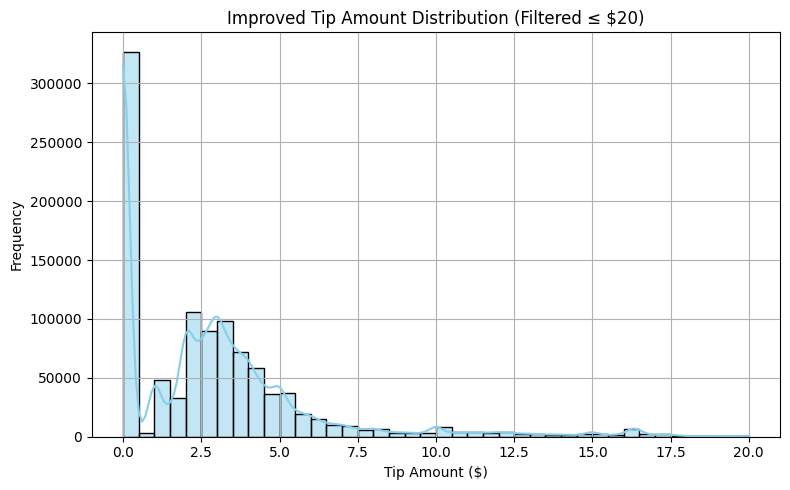

In [30]:
from pyspark.sql.functions import col, avg, stddev, min as spark_min, max as spark_max, desc

# Filter valid tips
df_tip_only = df.filter(col("tip_amount") >= 0)

# Calculate average and standard deviation
tip_stats = df_tip_only.select(
    avg("tip_amount").alias("avg_tip"),
    stddev("tip_amount").alias("stddev_tip")
).collect()[0]

print(f"✅ Average Tip: ${tip_stats['avg_tip']:.2f}")
print(f"✅ Tip Standard Deviation: ${tip_stats['stddev_tip']:.2f}")

# Min, Max, Top 5
min_tip = df_tip_only.select(spark_min("tip_amount")).first()[0]
max_tip = df_tip_only.select(spark_max("tip_amount")).first()[0]
top_5_tips = df_tip_only.select("tip_amount").orderBy(desc("tip_amount")).limit(5).toPandas()

print(f"✅ Min Tip: ${min_tip}")
print(f"✅ Max Tip: ${max_tip}")
print("✅ Top 5 Tip Amounts:")
print(top_5_tips)

# Sample & Filter out very high tips (outliers) to get a clearer graph
tip_pd = df_tip_only.filter(col("tip_amount") <= 20).select("tip_amount").sample(False, 0.1, seed=1).toPandas()

# Plot improved tip distribution
plt.figure(figsize=(8,5))
sns.histplot(tip_pd["tip_amount"], bins=40, kde=True, color='skyblue')
plt.xlabel("Tip Amount ($)")
plt.ylabel("Frequency")
plt.title("Improved Tip Amount Distribution (Filtered ≤ $20)")
plt.grid(True)
plt.tight_layout()
plt.show()


Most passengers give a small tip, with a wide range in tip amounts. While typical tips cluster around lower values, there are occasional very large tips, which are rare and considered outliers. This pattern shows tipping is common but varies greatly between rides.

### D. Identify Zones Generating Highest/Lowest Revenue

In this part, we find out which pick up or drop off zones bring the most and least revenue. This helps understand where taxi drivers earn more money.

In [31]:
drive.mount('/content/drive')

# Correct path to the file in your Google Drive
zone_file_path = "/content/drive/MyDrive/nyc_data/taxi_zone_lookup.csv"

# ✅ Use the correct file path when reading the CSV
zones_df = spark.read.csv(zone_file_path, header=True, inferSchema=True)

# Required imports
from pyspark.sql.functions import sum as spark_sum, col

# Calculate total revenue by pickup location
pickup_revenue = df.groupBy("PULocationID") \
                   .agg(spark_sum("fare_amount").alias("total_revenue")) \
                   .join(zones_df, df.PULocationID == zones_df.LocationID, "left") \
                   .select("Zone", "total_revenue") \
                   .orderBy(col("total_revenue").desc())

# Show top 10 highest revenue zones
print("🔝 Top 10 Pickup Zones by Revenue")
pickup_revenue.show(10, truncate=False)

# Show bottom 10 zones (excluding zero revenue)
print("🔻 Bottom 10 Pickup Zones by Revenue (Excluding Zero)")
pickup_revenue.filter(col("total_revenue") > 0) \
              .orderBy("total_revenue") \
              .show(10, truncate=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔝 Top 10 Pickup Zones by Revenue
+----------------------------+-------------------+
|Zone                        |total_revenue      |
+----------------------------+-------------------+
|JFK Airport                 |2.510521516999928E7|
|LaGuardia Airport           |1.251476369000018E7|
|Midtown Center              |7689485.709999911  |
|Times Sq/Theatre District   |6305155.189999995  |
|Upper East Side South       |5961562.790000164  |
|Upper East Side North       |5761498.170000258  |
|Penn Station/Madison Sq West|5492176.730000049  |
|Midtown East                |5185060.0000000475 |
|East Chelsea                |4480965.280000075  |
|Midtown North               |4431286.30000003   |
+----------------------------+-------------------+
only showing top 10 rows

🔻 Bottom 10 Pickup Zones by Revenue (Excluding Zero)
+---------------------------------+----------

Certain zones, like major airports and busy city centers, generate the highest taxi revenue, indicating strong demand in these areas. Conversely, some zones with very low revenue suggest limited taxi activity or fewer rides starting there. Understanding this helps drivers focus on profitable areas.

### E. Analyze High-Value Trips (Fare > $100)

In this part, we find trips where the fare was more than $100. These are called high-value trips. We look at how many such trips exist, their average distance, and trip time.

In [35]:
from pyspark.sql.functions import col, avg, stddev,count, min as spark_min, max as spark_max, desc

# Add trip duration in minutes
df = df.withColumn(
    "trip_duration_minutes",
    (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60
)

# Filter trips with fare > $100 (high-value trips)
high_value_trips = df.filter(col("fare_amount") > 100)

# Aggregate summary stats for high-value trips
high_value_summary = high_value_trips.select(
    count("*").alias("total_high_value_trips"),
    avg("trip_distance").alias("avg_distance"),
    avg("trip_duration_minutes").alias("avg_duration_minutes"),
    avg("fare_amount").alias("avg_fare")
).collect()[0]

# Print summary
print("High-Value Trips Analysis:")
print(f"Total Trips: {high_value_summary['total_high_value_trips']}")
print(f"Average Distance: {high_value_summary['avg_distance']:.2f} miles")
print(f"Average Duration: {high_value_summary['avg_duration_minutes']:.2f} minutes")
print(f"Average Fare: ${high_value_summary['avg_fare']:.2f}")


High-Value Trips Analysis:
Total Trips: 21964
Average Distance: 27.44 miles
Average Duration: 57.39 minutes
Average Fare: $192.55


High value trips are generally longer and take more time, resulting in higher fares.These trips tend to cover a long distance and take almost an hour on average. Because they last longer and go farther, the fare is much higher compared to regular trips. This shows that high-value trips are generally longer rides with higher earnings.

### F. Compare Short vs. Long Trip Profitability

Here, we compare short trips and long trips to see which ones are more profitable. A short trip is < median_distance miles, and a long trip is > median_distance miles. We compare average fare and revenue per mile.

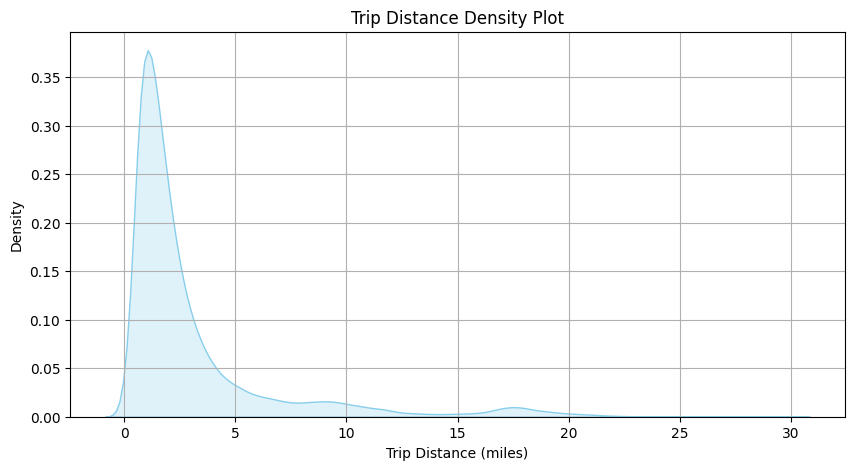

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample the data and convert to Pandas if not already done
trip_sample = df.select("trip_distance").sample(False, 0.05).toPandas()

# Filter out extreme outliers to better visualize
trip_sample = trip_sample[trip_sample["trip_distance"] < 30]

# Plot smooth KDE curve
plt.figure(figsize=(10, 5))
sns.kdeplot(data=trip_sample, x="trip_distance", fill=True, color="skyblue", bw_adjust=1)

plt.xlabel("Trip Distance (miles)")
plt.ylabel("Density")
plt.title("Trip Distance Density Plot")
plt.grid(True)
plt.show()


We can use the median trip distance as the threshold to split short and long trips, because the data is skewed and most trips are short.

In [41]:
from pyspark.sql.functions import avg
import numpy as np

#Compute the median trip distance using approxQuantile
median_distance = df.approxQuantile("trip_distance", [0.5], 0.01)[0]
print(f"📐 Median Trip Distance: {median_distance:.2f} miles")


📐 Median Trip Distance: 1.74 miles


In [42]:
from pyspark.sql.functions import col, avg

# Filter trips
short_trips = df.filter(col("trip_distance") <= median_distance)
long_trips  = df.filter(col("trip_distance") > median_distance)

# Compute profitability metrics
short_summary = short_trips.withColumn("rev_per_mile", col("fare_amount") / col("trip_distance")) \
    .select(
        avg("fare_amount").alias("avg_fare_short"),
        avg("rev_per_mile").alias("rev_per_mile_short")
    ).collect()[0]

long_summary = long_trips.withColumn("rev_per_mile", col("fare_amount") / col("trip_distance")) \
    .select(
        avg("fare_amount").alias("avg_fare_long"),
        avg("rev_per_mile").alias("rev_per_mile_long")
    ).collect()[0]

# Display results
print(f"✅ Short trips (≤ {median_distance:.2f} mi): Avg Fare = ${short_summary['avg_fare_short']:.2f}, Revenue/Mile = ${short_summary['rev_per_mile_short']:.2f}")
print(f"✅ Long trips  (> {median_distance:.2f} mi): Avg Fare = ${long_summary['avg_fare_long']:.2f}, Revenue/Mile = ${long_summary['rev_per_mile_long']:.2f}")


✅ Short trips (≤ 1.74 mi): Avg Fare = $9.89, Revenue/Mile = $27.07
✅ Long trips  (> 1.74 mi): Avg Fare = $27.02, Revenue/Mile = $5.94



* Short trips bring in a higher amount of money per mile, even though the total fare is low. These trips are more profitable per distance traveled.
* Long trips give more total fare, but since they cover more distance, the revenue per mile is much lower. They're less profitable per mile, but may still be worth it overall due to higher fare totals.

## Section 4: Temporal & Time Series Analysis
We explore trip activity patterns across time. This includes analyzing the distribution of rides by hour, day of the week, and comparing weekday vs. weekend traffic. Visualizations highlight when NYC sees the most taxi activity.

#### 1. Aggregate Trip Volume by Time Intervals (Daily/Monthly/Yearly)

In [ ]:
from pyspark.sql.functions import year

df = df.filter((year(df.pickup_datetime) >= 2015) & (year(df.pickup_datetime) <= 2025))


In [ ]:
df.createOrReplaceTempView("trips")

# Daily trip counts
daily_trips = spark.sql("""
SELECT
    DATE(pickup_datetime) as date,
    COUNT(*) as trip_count
FROM trips
GROUP BY DATE(pickup_datetime)
ORDER BY date
""")


In [ ]:
daily_trips.show()

In [ ]:
daily_pd = daily_trips.toPandas()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily_pd['date'], daily_pd['trip_count'], marker='o')
plt.title("Daily NYC Trip Volume")
plt.xlabel("Date")
plt.ylabel("Trip Count")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
monthly_trips = spark.sql("""
SELECT
    YEAR(pickup_datetime) AS year,
    MONTH(pickup_datetime) AS month,
    COUNT(*) AS trip_count
FROM trips
GROUP BY YEAR(pickup_datetime), MONTH(pickup_datetime)
ORDER BY year, month
""")

In [ ]:
monthly_trips.show()

In [ ]:
monthly_pd = monthly_trips.toPandas()
monthly_pd['month_start'] = pd.to_datetime(monthly_pd[['year', 'month']].assign(day=1))
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(monthly_pd['month_start'], monthly_pd['trip_count'], marker='o', linestyle='-')
plt.title("Monthly Trip Volume")
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
yearly_trips = spark.sql("""
SELECT
    YEAR(pickup_datetime) AS year,
    COUNT(*) AS trip_count
FROM trips
GROUP BY YEAR(pickup_datetime)
ORDER BY year
""")


In [ ]:
yearly_trips.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(8, 5))
plt.bar(yearly_pd['year'], yearly_pd['trip_count'], color='skyblue')
plt.title("Yearly Trip Volume")
plt.xlabel("Year")
plt.ylabel("Number of Trips")
plt.grid(axis='y')

# Ensure x-axis only shows whole numbers
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


#### 2. Study Patterns by Hour / Day of Week / Month

In [ ]:
# Required libraries
from pyspark.sql.functions import hour, dayofweek, date_format, col
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df.createOrReplaceTempView("trips")

trips_by_hour = spark.sql("""
    SELECT hour(pickup_datetime) AS hour, COUNT(*) AS trip_count
    FROM trips
    GROUP BY hour
    ORDER BY hour
""")


In [ ]:
trips_by_hour.show()

In [ ]:
import matplotlib.pyplot as plt
pdf = trips_by_hour.toPandas()

# Make sure data is sorted by hour
pdf = pdf.sort_values("hour")

plt.figure(figsize=(10, 6))
plt.plot(pdf["hour"], pdf["trip_count"], marker='o', linestyle='-', color='blue')

plt.title("Trips by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
trips_by_dow = spark.sql("""
    SELECT dayofweek(pickup_datetime) AS day_of_week, COUNT(*) AS trip_count
    FROM trips
    GROUP BY day_of_week
    ORDER BY day_of_week
""")

trips_by_dow.show()

In [ ]:
pdf_dow = trips_by_dow.toPandas().sort_values("day_of_week")

# Optional: Replace numbers with day names (1 = Sunday, 7 = Saturday)
import calendar
pdf_dow["day_name"] = pdf_dow["day_of_week"].apply(lambda x: calendar.day_name[(x % 7)])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(pdf_dow["day_name"], pdf_dow["trip_count"], marker='o')
plt.title("Trips by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
trips_by_month = spark.sql("""
    SELECT month(pickup_datetime) AS month, COUNT(*) AS trip_count
    FROM trips
    GROUP BY month
    ORDER BY month
""")
trips_by_month.show()

pdf_month = trips_by_month.toPandas().sort_values("month")

# Optional: Month name mapping
pdf_month["month_name"] = pdf_month["month"].apply(lambda x: calendar.month_name[x])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(pdf_month["month_name"], pdf_month["trip_count"], marker='o')
plt.title("Trips by Month")
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 3. Decompose Time Series (Trend, Seasonality)

In [ ]:
pdf_daily = daily_trips.toPandas().sort_values("date")
pdf_daily["date"] = pd.to_datetime(pdf_daily["date"])
pdf_daily.set_index("date", inplace=True)


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure data is regularly spaced (daily), or reindex with missing days filled if needed
# You can interpolate or fill missing dates if necessary

# Decompose (model='additive' or 'multiplicative')
result = seasonal_decompose(pdf_daily["trip_count"], model='additive', period=7)  # weekly seasonality

# Plot
result.plot()
plt.tight_layout()
plt.show()


In [ ]:
# pdf_monthly = monthly_trips.toPandas().sort_values("month")

# # Convert month to datetime and set index
# pdf_monthly["month"] = pd.to_datetime(pdf_monthly["month"])
# pdf_monthly.set_index("month", inplace=True)
# pdf_monthly = pdf_monthly.asfreq('MS')  # MS = Month Start


In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# import matplotlib.pyplot as plt

# # Perform decomposition with yearly seasonality (period=12)
# result = seasonal_decompose(pdf_monthly["trip_count"], model='additive', period=12)

# # Plot the decomposed components
# result.plot()
# plt.tight_layout()
# plt.show()


#### Rolling Average of Daily Trips or Revenue

In [ ]:
# from pyspark.sql.window import Window
# from pyspark.sql.functions import avg

# # Define a window of previous 6 days + current day = 7-day rolling average
# window_spec = Window.orderBy("trip_date").rowsBetween(-6, 0)

# df_rolling = daily_trips.withColumn("rolling_avg_7d", avg("trip_count").over(window_spec))

# df_rolling.show()


In [ ]:
pdf["rolling_avg_7d"] = pdf["trip_count"].rolling(window=7).mean()


#### 6. Time-Based Clustering (e.g., Peak vs. Off-Peak)


In [ ]:
from pyspark.sql.functions import col, hour, when

# Step 1: Extract hour from pickup_datetime
df = df.withColumn("hour", hour(col("pickup_datetime")))

# Step 2: Create time_segment based on hour
df = df.withColumn("time_segment",
    when((col("hour") >= 7) & (col("hour") <= 9), "morning_peak")
    .when((col("hour") >= 17) & (col("hour") <= 19), "evening_peak")
    .otherwise("off_peak")
)


In [ ]:
trips_by_segment = df.groupBy("time_segment").count().orderBy("time_segment")
trips_by_segment.show()


In [ ]:
pdf = trips_by_segment.toPandas()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(data=pdf, x="time_segment", y="count", order=["morning_peak", "off_peak", "evening_peak"])
plt.title("Number of Trips by Time Segment")
plt.xlabel("Time Segment")
plt.ylabel("Number of Trips")
plt.show()


#### 7. Build Models to Forecast Demand (ARIMA, Prophet)


In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

pdf = daily_trips.toPandas()
pdf = pdf.rename(columns={"date": "ds", "trip_count": "y"})

model = Prophet()
model.fit(pdf)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Only main forecast plot
fig = model.plot(forecast)
fig.show()


## Section 5: Trip Fare Prediction